### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'cancer_type_range'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

# 'aupr' or 'auroc'
metric = 'aupr'

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'generalization_plots'
)

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(51480, 6)
['MAP3K1' 'TP53' 'RB1' 'CIC' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2'
 'ARID1A' 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4'
 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS'
 'CTNNB1' 'PTEN' 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM'
 'CDH1' 'BAP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2'
 'CASP8' 'SPOP' 'PPP2R1A' 'KRAS']


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,MAP3K1,BRCA,1.0,1,0,140
1,MAP3K1,BRCA,1.0,1,1,144
2,MAP3K1,BRCA,1.0,1,2,136
3,MAP3K1,BRCA,1.0,1,3,108
4,MAP3K1,BRCA,10000.0,1,0,7171


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(154440, 10)
['MAP3K1' 'TP53' 'RB1' 'CIC' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2'
 'ARID1A' 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4'
 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS'
 'CTNNB1' 'PTEN' 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM'
 'CDH1' 'BAP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2'
 'CASP8' 'SPOP' 'PPP2R1A' 'KRAS']


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,0,all_other_cancers,1.0
1,0.45284,0.088349,MAP3K1,BRCA,signal,1,test,0,all_other_cancers,1.0
2,0.32208,0.043041,MAP3K1,BRCA,signal,1,cv,0,all_other_cancers,1.0
3,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,1,all_other_cancers,1.0
4,0.56136,0.129500,MAP3K1,BRCA,signal,1,test,1,all_other_cancers,1.0


### Compare feature selection with performance

In [5]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal', 'experiment'])
)

print(coefs_perf_df.shape)
coefs_perf_df.head()

(154440, 9)


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
0,MAP3K1,BRCA,1.0,1,0,140,1.00000,1.000000,train
1,MAP3K1,BRCA,1.0,1,0,140,0.45284,0.088349,test
2,MAP3K1,BRCA,1.0,1,0,140,0.32208,0.043041,cv
3,MAP3K1,BRCA,1.0,1,1,144,1.00000,1.000000,train
4,MAP3K1,BRCA,1.0,1,1,144,0.56136,0.129500,test


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
91058,ATRX,SKCM,0.001,1,0,0,0.5,0.161340,cv
62147,KDM6A,BLCA,0.001,1,3,0,0.5,0.095436,cv
62208,KDM6A,HNSC,0.001,1,0,0,0.5,0.128600,train
62209,KDM6A,HNSC,0.001,1,0,0,0.5,0.074380,test
62210,KDM6A,HNSC,0.001,1,0,0,0.5,0.164080,cv
62211,KDM6A,HNSC,0.001,1,1,0,0.5,0.147450,train
62212,KDM6A,HNSC,0.001,1,1,0,0.5,0.057851,test
62213,KDM6A,HNSC,0.001,1,1,0,0.5,0.126390,cv


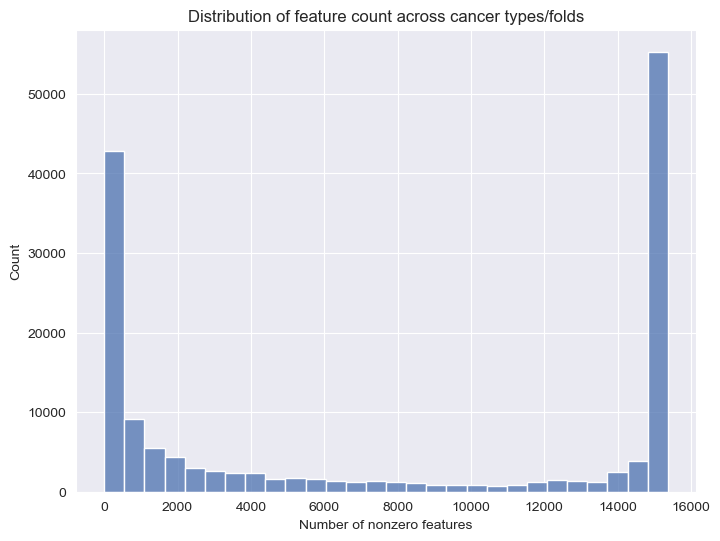

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero features')

coefs_perf_df.loc[coefs_perf_df.nz_coefs.sort_values()[:8].index, :]

### Get "best" LASSO parameters and compare performance across all genes

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll do this for each gene/cancer type in the dataset below, and plot the distribution of differences between the two strategies, as a way to quantify which strategy is "better" for generalization across cancer types.

In [7]:
def get_top_and_smallest_diff(gene, cancer_type, top_proportion=0.25):
    top_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    rank_cutoff = ceil(perf_df.lasso_param.unique().shape[0] * top_proportion)
    params_above_cutoff = top_df.loc[top_df.aupr_rank <= rank_cutoff, :].index
    
    # get parameter with best validation performance
    top_lasso_param = params_above_cutoff[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.gene == gene) & 
                    (nz_coefs_df.cancer_type == cancer_type) &
                    (nz_coefs_df.lasso_param.isin(params_above_cutoff))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    holdout_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'test') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    
    top_smallest_diff = (
        holdout_df.loc[top_lasso_param, 'mean_aupr'] -
        holdout_df.loc[smallest_lasso_param, 'mean_aupr']
    )
    return [gene, cancer_type, top_lasso_param, smallest_lasso_param, top_smallest_diff]

print(get_top_and_smallest_diff('SETD2', 'KIRP'))

['SETD2', 'KIRP', 10.0, 0.0316, 0.13593624999999998]


In [8]:
all_top_smallest_diff_df = []

for gene in perf_df.gene.unique():
    for cancer_type in perf_df[perf_df.gene == gene].holdout_cancer_type.unique():
        all_top_smallest_diff_df.append(get_top_and_smallest_diff(gene, cancer_type))
        
all_top_smallest_diff_df = pd.DataFrame(
    all_top_smallest_diff_df,
    columns=['gene', 'cancer_type', 'top_lasso_param',
             'smallest_lasso_param', 'top_smallest_diff']
)

all_top_smallest_diff_df['best'] = 'top'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff < 0, 'best'
] = 'smallest'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff == 0, 'best'
] = 'zero'

print(all_top_smallest_diff_df.best.value_counts())
all_top_smallest_diff_df.head()

top         133
smallest     84
zero         77
Name: best, dtype: int64


,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
0,MAP3K1,BRCA,0.0316,0.0100,-0.000609,smallest
1,MAP3K1,UCEC,3.1600,0.0316,-0.003637,smallest
2,TP53,SARC,0.0316,0.0100,0.040756,top
3,TP53,SKCM,0.0316,0.0100,0.046975,top
4,TP53,KICH,0.0316,0.0100,0.010342,top


In [9]:
(all_top_smallest_diff_df
  .sort_values(by='top_smallest_diff', ascending=False)
  .to_csv(cfg.generalization_data_dir / 'cancer_type_best_vs_smallest.tsv', sep='\t')
)

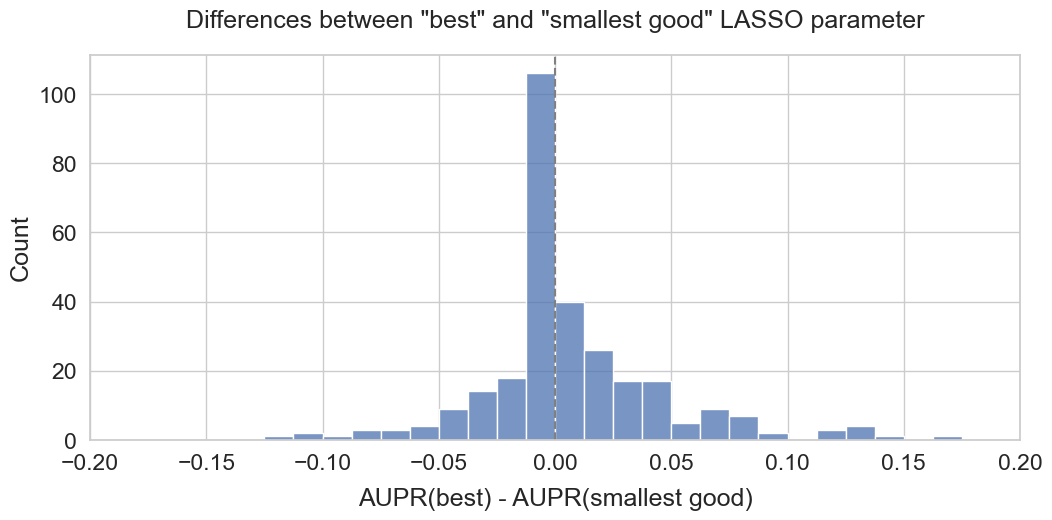

In [10]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.5):
    sns.histplot(all_top_smallest_diff_df.top_smallest_diff,
                 binwidth=0.0125, binrange=(-0.2, 0.2))
    plt.xlim(-0.2, 0.2)
    plt.title('Differences between "best" and "smallest good" LASSO parameter', y=1.05)
    plt.xlabel('AUPR(best) - AUPR(smallest good)', labelpad=10)
    plt.gca().axvline(0, color='grey', linestyle='--')

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, 'all_best_vs_smallest_good.svg'),
                bbox_inches='tight')

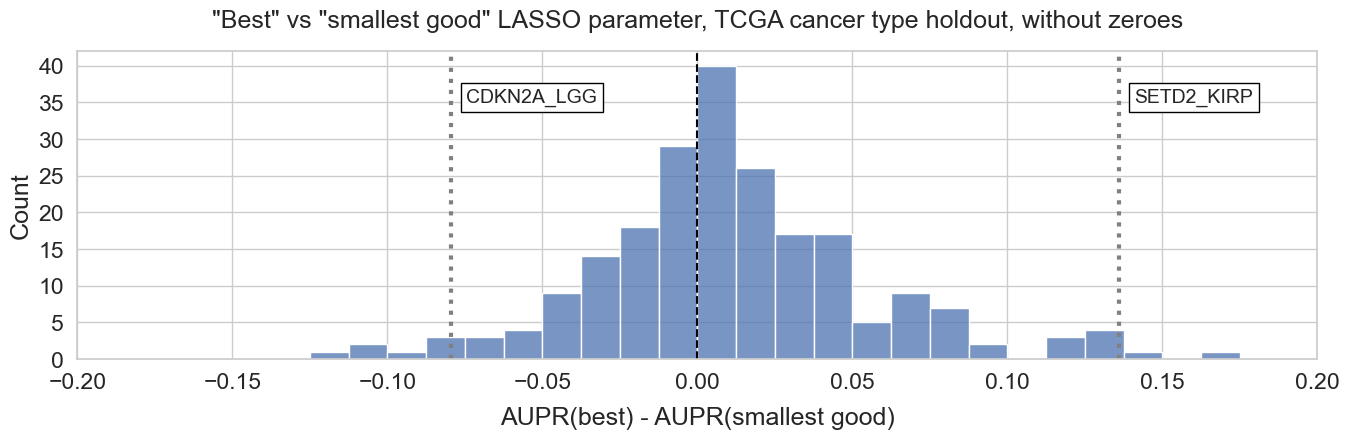

In [11]:
sns.set({'figure.figsize': (16, 4)})
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.5):
    sns.histplot(
        all_top_smallest_diff_df[all_top_smallest_diff_df.top_smallest_diff != 0.0].top_smallest_diff,
        binwidth=0.0125, binrange=(-0.2, 0.2)
    )
    plt.xlim(-0.2, 0.2)
    plt.title('"Best" vs "smallest good" LASSO parameter, TCGA cancer type holdout, without zeroes', y=1.05)
    plt.xlabel('AUPR(best) - AUPR(smallest good)', labelpad=10)
    plt.gca().axvline(0, color='black', linestyle='--')
    
# one "best" example and one "smallest good" example
for plot_gene, plot_cancer_type in [('SETD2', 'KIRP'), ('CDKN2A', 'LGG')]:
    gene_cancer_diff = all_top_smallest_diff_df[
        (all_top_smallest_diff_df.gene == plot_gene) &
        (all_top_smallest_diff_df.cancer_type == plot_cancer_type)
    ].top_smallest_diff.values[0]
    plt.gca().axvline(gene_cancer_diff, color='grey', linestyle=':', linewidth=3)
    plt.gca().text(
        gene_cancer_diff+0.005, 35, 
        f'{plot_gene}_{plot_cancer_type}',
        size=14,
        bbox={'facecolor': 'white', 'edgecolor': 'black'}
    )

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, 'all_best_vs_smallest_good_no_zeroes.svg'),
                bbox_inches='tight')

In [12]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=False).head(10)

,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
136,SMAD4,READ,0.0316,0.01000,0.241196,top
213,PIK3CA,READ,0.0316,0.01000,0.166598,top
255,NF1,SARC,0.0100,0.00316,0.145662,top
275,SETD2,KIRP,10.0000,0.03160,0.135936,top
243,BAP1,LIHC,0.0316,0.01000,0.135791,top
241,BAP1,KIRC,0.0316,0.01000,0.131483,top
199,PTEN,CESC,0.0316,0.01000,0.130605,top
170,EP300,CESC,10.0000,0.01000,0.122706,top
151,FBXW7,CESC,10.0000,0.03160,0.122401,top
274,SETD2,KIRC,10.0000,0.10000,0.121466,top


In [13]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=True).head(10)

,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
263,NFE2L2,UCEC,0.0316,0.01000,-0.118285,smallest
185,CTNNB1,LIHC,3.1600,0.03160,-0.102559,smallest
143,FGFR2,STAD,31.6000,0.10000,-0.100718,smallest
186,CTNNB1,SKCM,3.1600,0.10000,-0.093093,smallest
253,NF1,STAD,0.0100,0.00316,-0.080023,smallest
51,CDKN2A,LGG,0.0316,0.01000,-0.079471,smallest
242,BAP1,MESO,0.3160,0.03160,-0.075534,smallest
19,TP53,LGG,0.0316,0.01000,-0.074928,smallest
60,CDKN2A,SARC,0.0316,0.01000,-0.074809,smallest
252,NF1,UCEC,0.0100,0.00316,-0.068907,smallest


### Visualize performance by cancer type

We'll do this using the "best" parameters.

In [14]:
cv_perf_df = (
    perf_df[(perf_df.data_type == 'cv') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
      .rename(columns={'holdout_cancer_type': 'cancer_type'})
).copy()
cv_perf_df.lasso_param = cv_perf_df.lasso_param.astype(float)

print(cv_perf_df.shape)
cv_perf_df.head()

(51480, 8)


,auroc,aupr,gene,cancer_type,seed,data_type,fold,lasso_param
2,0.32208,0.043041,MAP3K1,BRCA,1,cv,0,1.000
5,0.50817,0.107610,MAP3K1,BRCA,1,cv,1,1.000
8,0.46894,0.052835,MAP3K1,BRCA,1,cv,2,1.000
11,0.37587,0.075614,MAP3K1,BRCA,1,cv,3,1.000
2,0.76706,0.453930,MAP3K1,UCEC,1,cv,0,0.316


In [15]:
test_perf_df = (
    perf_df[(perf_df.data_type == 'test') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
      .rename(columns={'holdout_cancer_type': 'cancer_type'})
).copy()
test_perf_df.lasso_param = test_perf_df.lasso_param.astype(float)

print(test_perf_df.shape)
test_perf_df.head()

(51480, 8)


,auroc,aupr,gene,cancer_type,seed,data_type,fold,lasso_param
1,0.45284,0.088349,MAP3K1,BRCA,1,test,0,1.000
4,0.56136,0.129500,MAP3K1,BRCA,1,test,1,1.000
7,0.40375,0.077118,MAP3K1,BRCA,1,test,2,1.000
10,0.33258,0.073561,MAP3K1,BRCA,1,test,3,1.000
1,0.31190,0.032846,MAP3K1,UCEC,1,test,0,0.316


In [16]:
# get performance using "best" lasso parameter, across all seeds and folds
# (so we can plot the distribution/visualize the variance across CV splits)
best_perf_df = (
    all_top_smallest_diff_df.loc[:, ['gene', 'cancer_type', 'top_lasso_param']]
      .merge(cv_perf_df,
             left_on=['gene', 'cancer_type', 'top_lasso_param'],
             right_on=['gene', 'cancer_type', 'lasso_param'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'cv_auroc',
                       'aupr': 'cv_aupr'})
      .merge(test_perf_df,
             left_on=['gene', 'cancer_type', 'top_lasso_param', 'seed', 'fold'],
             right_on=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'test_auroc',
                       'aupr': 'test_aupr'})
)
best_perf_df['cv_test_auroc_diff'] = (
    best_perf_df.cv_auroc - best_perf_df.test_auroc
)
best_perf_df['cv_test_aupr_diff'] = (
    best_perf_df.cv_aupr - best_perf_df.test_aupr
)

print(best_perf_df.shape)
best_perf_df.sort_values(by='cv_test_aupr_diff', ascending=False).head()

(2340, 13)


,gene,cancer_type,top_lasso_param,cv_auroc,cv_aupr,seed,data_type_x,fold,test_auroc,test_aupr,data_type_y,cv_test_auroc_diff,cv_test_aupr_diff
265,CIC,UCEC,1.00,0.97451,0.91958,1,cv,1,0.084906,0.014877,test,0.889604,0.904703
287,BRAF,LUAD,1.00,0.95205,0.95019,1,cv,3,0.293640,0.060890,test,0.658410,0.889300
285,BRAF,LUAD,1.00,0.94274,0.93564,1,cv,1,0.425080,0.087449,test,0.517660,0.848191
731,NRAS,COAD,3.16,0.94659,0.85114,42,cv,3,0.277780,0.018868,test,0.668810,0.832272
282,BRAF,LUAD,1.00,0.94517,0.93622,42,cv,2,0.444280,0.109190,test,0.500890,0.827030


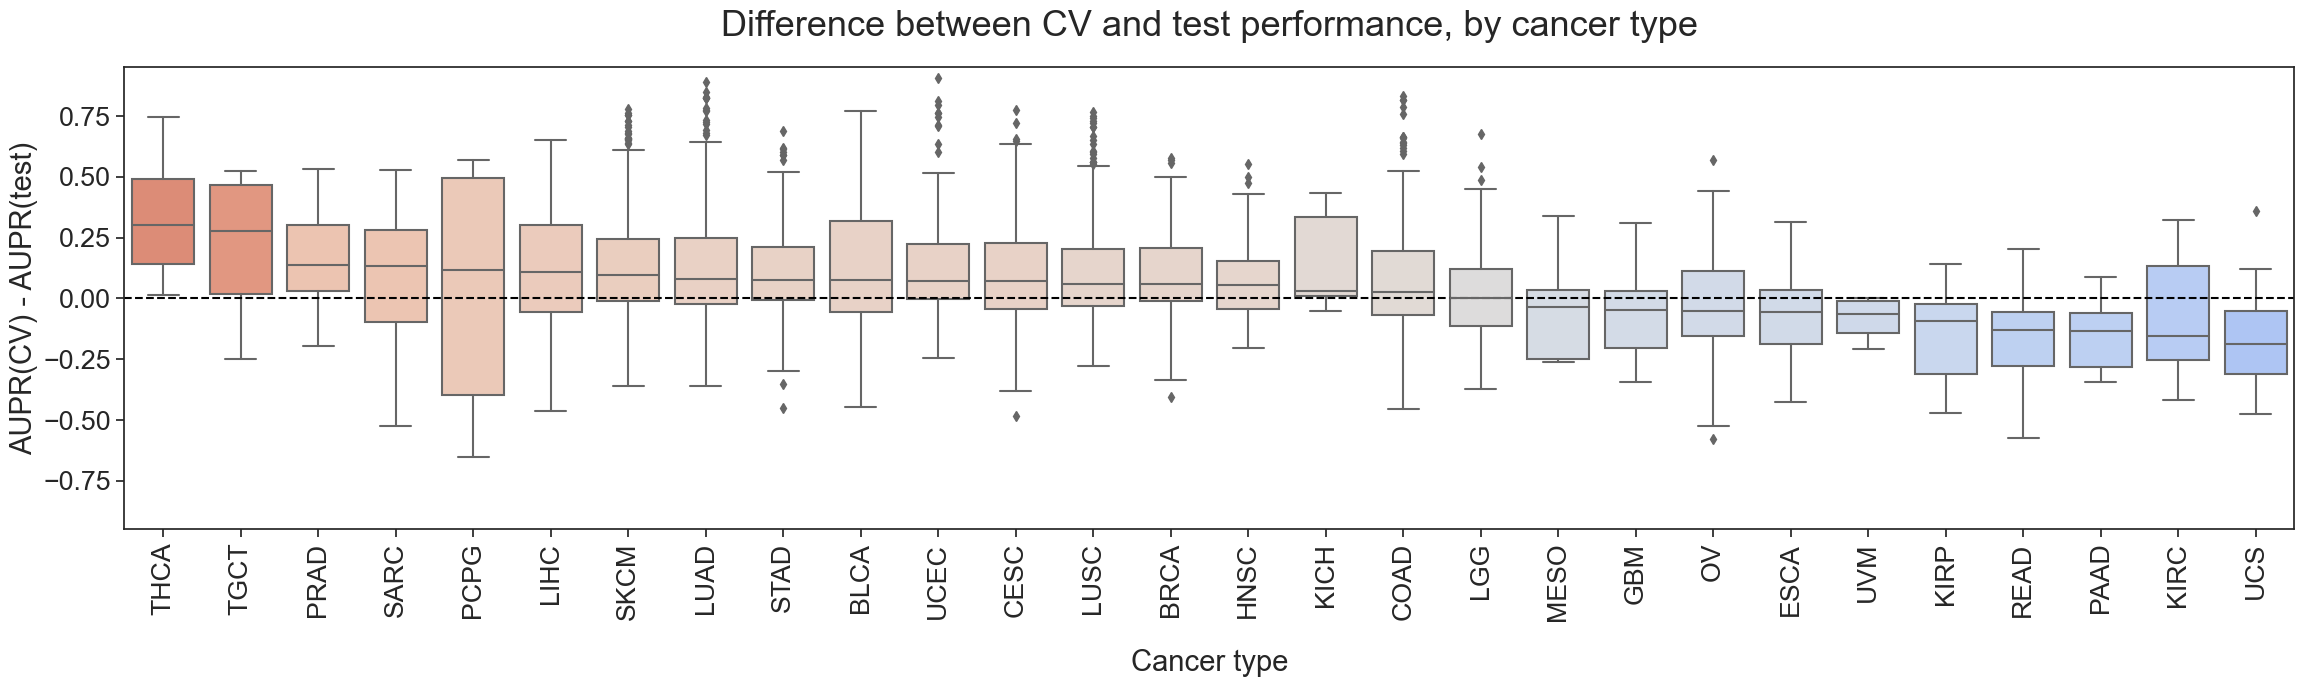

In [17]:
# plot difference in validation and test performance for each gene
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by median (cv - test) diff per gene
medians = (best_perf_df
    .groupby(['cancer_type'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
)['cv_test_aupr_diff'].values

cancer_type_order = (best_perf_df
    .groupby(['cancer_type'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.75):
    # map median performance values to colors on scale centered at 0
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    norm = Normalize(vmin=-0.5, vmax=0.5)
    ax = sns.boxplot(data=best_perf_df, order=cancer_type_order,
                     x='cancer_type', y='cv_test_aupr_diff',
                     palette=[cmap(norm(m)) for m in medians])
    ax.axhline(0.0, linestyle='--', color='black')
    plt.xticks(rotation=90)
    plt.xlabel('Cancer type', labelpad=20)
    plt.title(f'Difference between CV and test performance, by cancer type', size=26, y=1.05)
    plt.ylim(-0.95, 0.95)
    plt.ylabel('AUPR(CV) - AUPR(test)')
    
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, 'all_cancer_type_diffs.svg'),
                bbox_inches='tight')

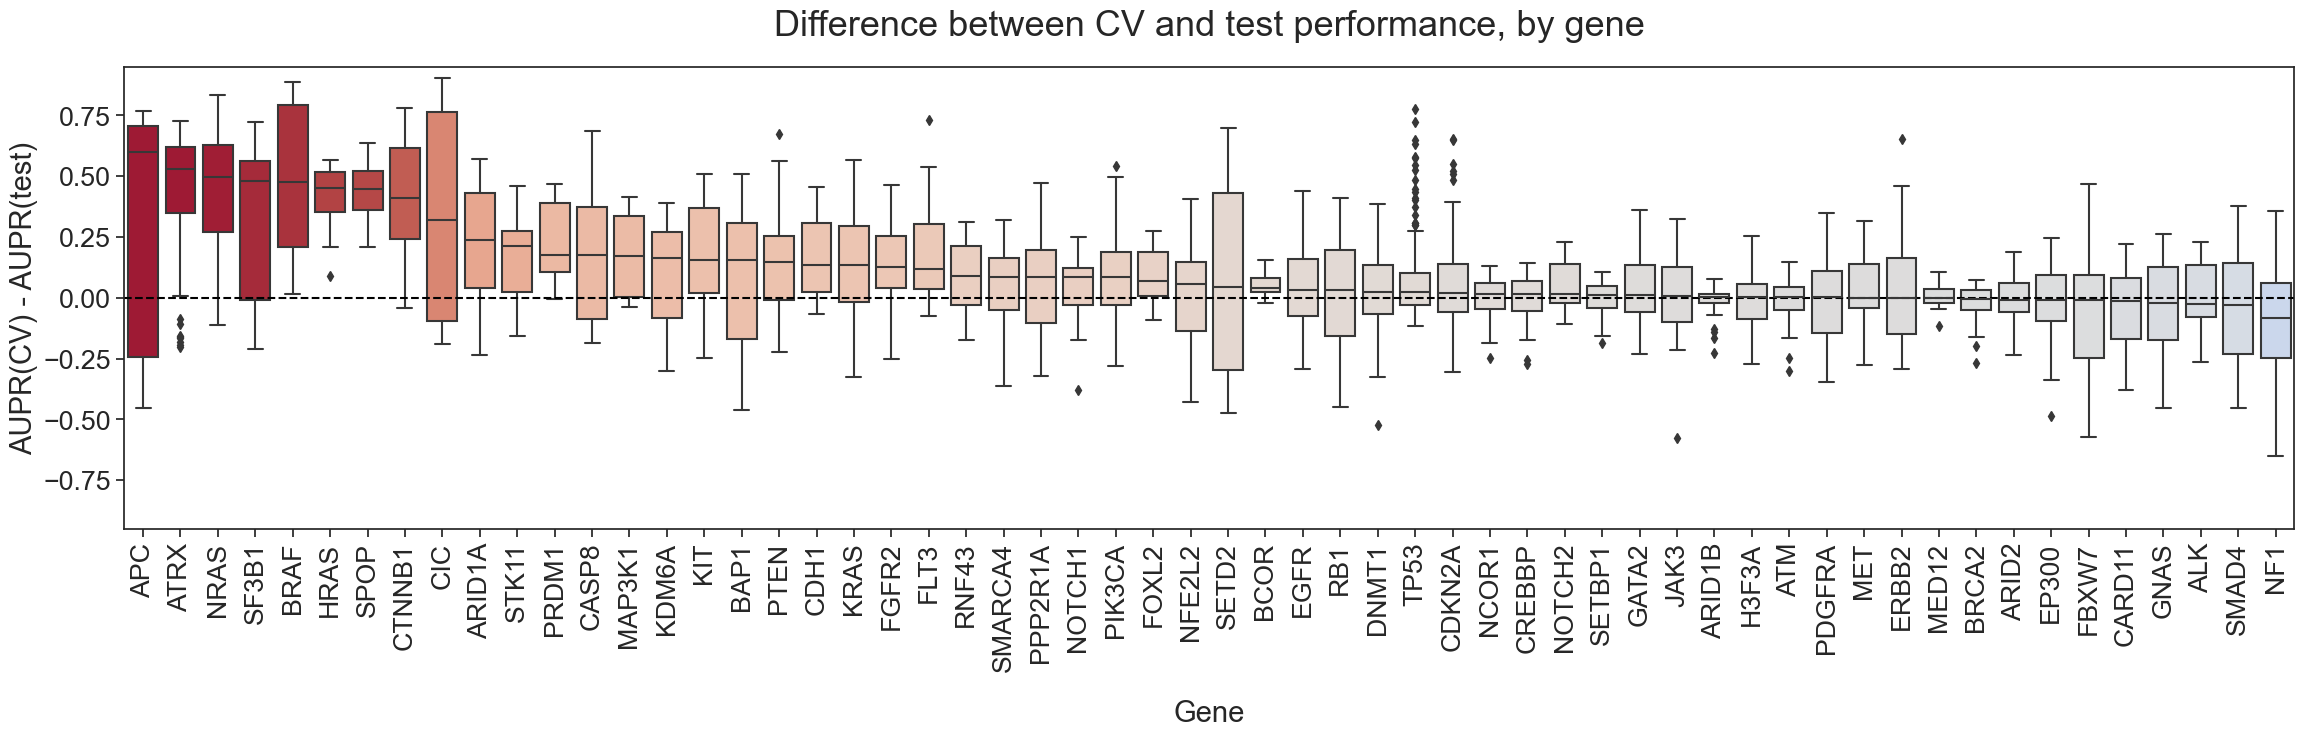

In [18]:
# plot difference in validation and test performance for each gene
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by median (cv - test) diff per gene
medians = (best_perf_df
    .groupby(['gene'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
)['cv_test_aupr_diff'].values

gene_order = (best_perf_df
    .groupby(['gene'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.75):
    # map median performance values to colors on scale centered at 0
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    norm = Normalize(vmin=-0.5, vmax=0.5)
    ax = sns.boxplot(data=best_perf_df, order=gene_order,
                     x='gene', y='cv_test_aupr_diff',
                     palette=[cmap(norm(m)) for m in medians])
    ax.axhline(0.0, linestyle='--', color='black')
    plt.xticks(rotation=90)
    plt.xlabel('Gene', labelpad=20)
    plt.title(f'Difference between CV and test performance, by gene', size=26, y=1.05)
    plt.ylim(-0.95, 0.95)
    plt.ylabel('AUPR(CV) - AUPR(test)')
    
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, 'all_gene_diffs.svg'),
                bbox_inches='tight')

In [19]:
gene_df = (best_perf_df
  .loc[:, ['gene', 'cancer_type']]
  .drop_duplicates(['gene', 'cancer_type'])
  .groupby('cancer_type')['gene']
  .apply(list)
  .to_frame()
  .rename(columns={'gene': 'gene_list'})
)
gene_df['num_genes'] = gene_df.gene_list.apply(len)

pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', 1000)
for cancer_type, row in gene_df.iterrows():
    print(cancer_type, row.gene_list)

BLCA ['TP53', 'RB1', 'ARID2', 'MET', 'CDKN2A', 'NCOR1', 'CREBBP', 'SMARCA4', 'ERBB2', 'ARID1A', 'PDGFRA', 'KDM6A', 'ARID1B', 'FBXW7', 'EGFR', 'APC', 'EP300', 'ATRX', 'PTEN', 'PIK3CA', 'CARD11', 'ATM', 'BAP1', 'SF3B1', 'NF1', 'NFE2L2', 'BRCA2', 'SETD2', 'CASP8', 'KRAS']
BRCA ['MAP3K1', 'TP53', 'RB1', 'H3F3A', 'NCOR1', 'ERBB2', 'GNAS', 'PTEN', 'PIK3CA', 'CDH1', 'SPOP']
CESC ['TP53', 'RB1', 'FOXL2', 'ERBB2', 'STK11', 'NOTCH1', 'FBXW7', 'EP300', 'PTEN', 'PIK3CA', 'GATA2', 'NFE2L2', 'KRAS']
COAD ['TP53', 'BRAF', 'FLT3', 'NRAS', 'ARID1A', 'SMAD4', 'FBXW7', 'APC', 'GNAS', 'PTEN', 'PIK3CA', 'ATM', 'KRAS']
ESCA ['TP53', 'CDKN2A', 'ERBB2', 'KDM6A', 'SMAD4', 'EGFR', 'PIK3CA', 'NFE2L2']
GBM ['TP53', 'CDKN2A', 'PDGFRA', 'EGFR', 'PTEN']
HNSC ['TP53', 'CDKN2A', 'CREBBP', 'KDM6A', 'NOTCH1', 'SMAD4', 'FBXW7', 'EGFR', 'EP300', 'HRAS', 'PTEN', 'PIK3CA', 'NOTCH2', 'NFE2L2', 'CASP8']
KICH ['TP53']
KIRC ['BAP1', 'SETD2']
KIRP ['MET', 'SETD2']
LGG ['TP53', 'CIC', 'CDKN2A', 'NOTCH1', 'EGFR', 'ATRX', 'PTEN', '

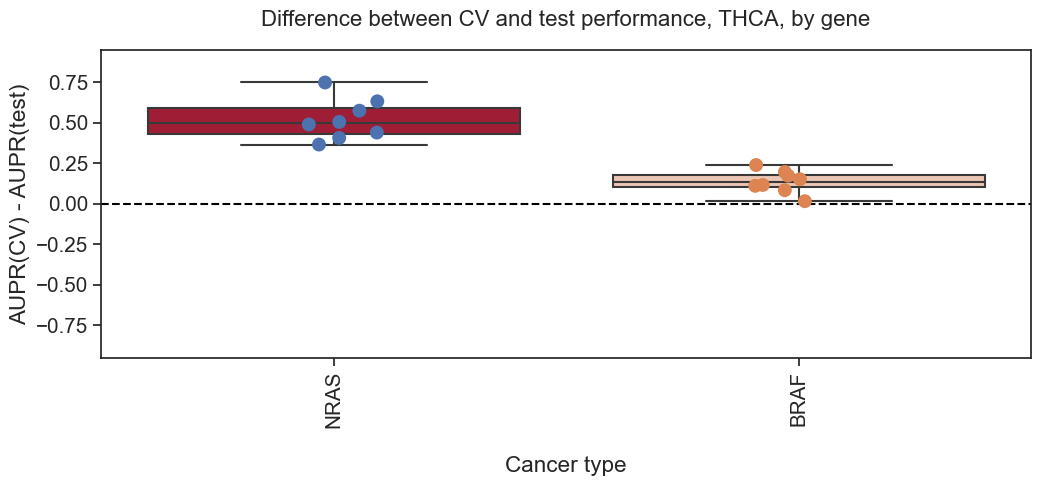

In [20]:
# plot difference in validation and test performance for each gene
sns.set({'figure.figsize': (12, 4)})
sns.set_style('ticks')

plot_cancer_type = 'THCA'

# order boxes by median (cv - test) diff per gene
medians = (best_perf_df[best_perf_df.cancer_type == plot_cancer_type]
    .groupby(['gene'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
)['cv_test_aupr_diff'].values

gene_order = (best_perf_df[best_perf_df.cancer_type == plot_cancer_type]
    .groupby(['gene'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.35):
    # map median performance values to colors on scale centered at 0
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    norm = Normalize(vmin=-0.5, vmax=0.5)
    ax = sns.boxplot(data=best_perf_df[best_perf_df.cancer_type == plot_cancer_type],
                     x='gene', y='cv_test_aupr_diff',
                     order=gene_order,
                     palette=[cmap(norm(m)) for m in medians])
    sns.stripplot(data=best_perf_df[best_perf_df.cancer_type == plot_cancer_type],
                  x='gene', y='cv_test_aupr_diff', order=gene_order, ax=ax, s=10)
    ax.axhline(0.0, linestyle='--', color='black')
    plt.xlabel('Cancer type', labelpad=20)
    plt.xticks(rotation=90)
    plt.title(f'Difference between CV and test performance, {plot_cancer_type}, by gene', size=16, y=1.05)
    plt.ylim(-0.95, 0.95)
    plt.ylabel('AUPR(CV) - AUPR(test)')
    
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{plot_cancer_type}_cancer_type_diffs_by_gene.svg'),
                bbox_inches='tight')

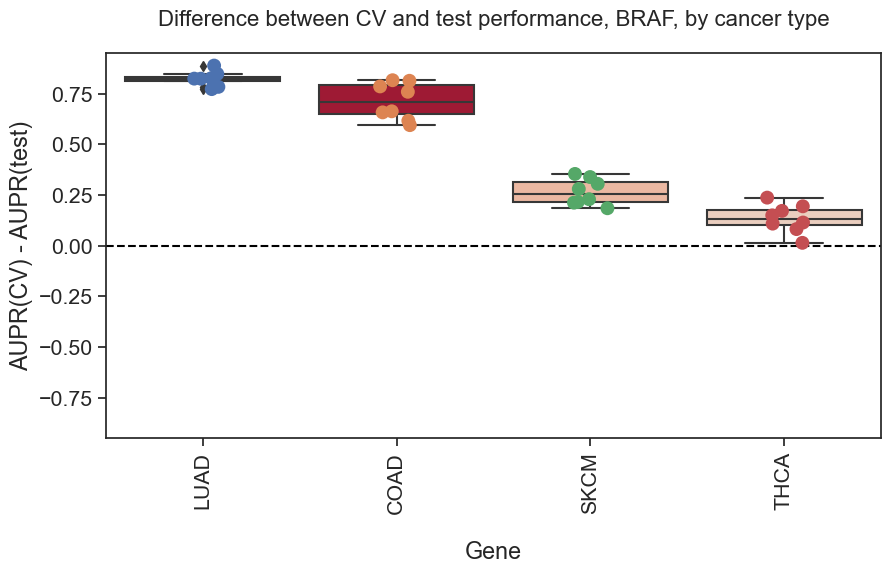

In [21]:
# plot difference in validation and test performance for each gene
sns.set({'figure.figsize': (10, 5)})
sns.set_style('ticks')

plot_gene = 'BRAF'

# order boxes by median (cv - test) diff per gene
medians = (best_perf_df[best_perf_df.gene == plot_gene]
    .groupby(['cancer_type'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
)['cv_test_aupr_diff'].values

cancer_type_order = (best_perf_df[best_perf_df.gene == plot_gene]
    .groupby(['cancer_type'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.4):
    # map median performance values to colors on scale centered at 0
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    norm = Normalize(vmin=-0.7, vmax=0.7)
    ax = sns.boxplot(data=best_perf_df[best_perf_df.gene == plot_gene],
                     x='cancer_type', y='cv_test_aupr_diff',
                     order=cancer_type_order,
                     palette=[cmap(norm(m)) for m in medians])
    sns.stripplot(data=best_perf_df[best_perf_df.gene == plot_gene],
                  x='cancer_type', y='cv_test_aupr_diff', order=cancer_type_order, ax=ax, s=10)
    ax.axhline(0.0, linestyle='--', color='black')
    plt.xticks(rotation=90)
    plt.xlabel('Gene', labelpad=20)
    plt.title(f'Difference between CV and test performance, {plot_gene}, by cancer type', size=16, y=1.05)
    plt.ylim(-0.95, 0.95)
    plt.ylabel('AUPR(CV) - AUPR(test)')
    
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_gene_diffs_by_cancer_type.svg'),
                bbox_inches='tight')